# Load Preview

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
# import dalex as dx


%matplotlib inline

In [ ]:
df = pd.read_csv('/content/Churn_Modelling.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
df.shape

(10000, 14)

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Pre-Processing

## Missing Values

In [ ]:
df.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


## Duplicate

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df[df.duplicated(subset=['CustomerId'],keep=False)].sort_values(by='CustomerId')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


## Outlier

In [ ]:
exclude_cols = ['CustomerID', 'RowNumber']
num_cols = df.select_dtypes(include='number').drop(columns=exclude_cols, errors='ignore')

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100
    print(f"{col}: {outlier_count} outliers ({outlier_percentage:.2f}%)")

CustomerId: 0 outliers (0.00%)
CreditScore: 15 outliers (0.15%)
Age: 359 outliers (3.59%)
Tenure: 0 outliers (0.00%)
Balance: 0 outliers (0.00%)
NumOfProducts: 60 outliers (0.60%)
HasCrCard: 0 outliers (0.00%)
IsActiveMember: 0 outliers (0.00%)
EstimatedSalary: 0 outliers (0.00%)
Exited: 2037 outliers (20.37%)


In [ ]:
#double cek plot
import scipy.stats as stats

def check_plot(df, variable):
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 3, 1)
    df[variable].hist(bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # Boxplot
    plt.subplot(1, 3, 3)
    df.boxplot(column=variable)
    plt.title('Boxplot')

    plt.suptitle(f'Check Plot untuk {variable}')
    plt.show()

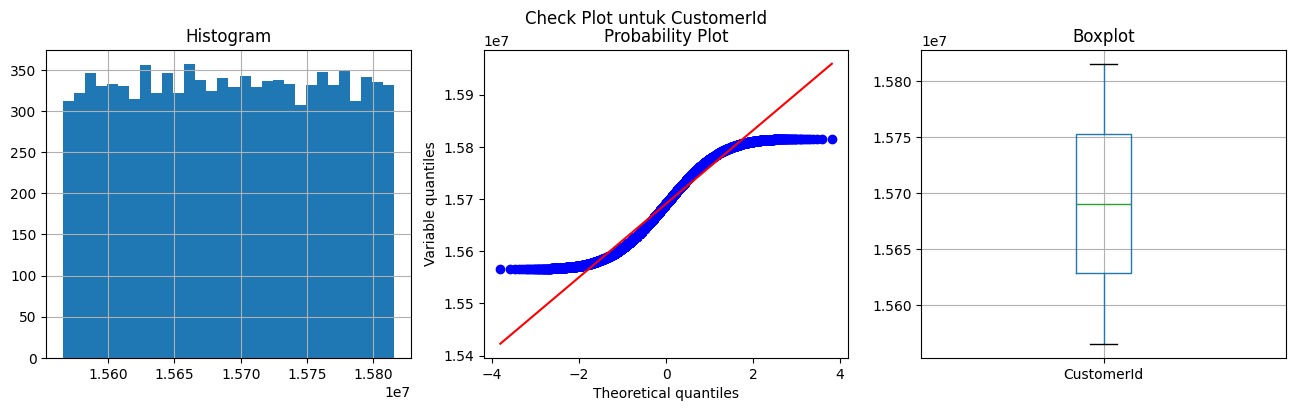

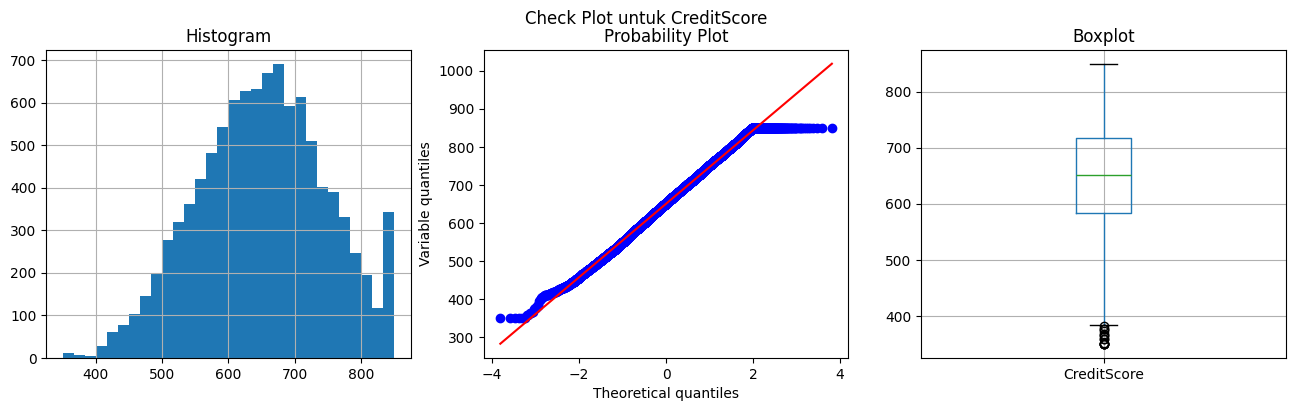

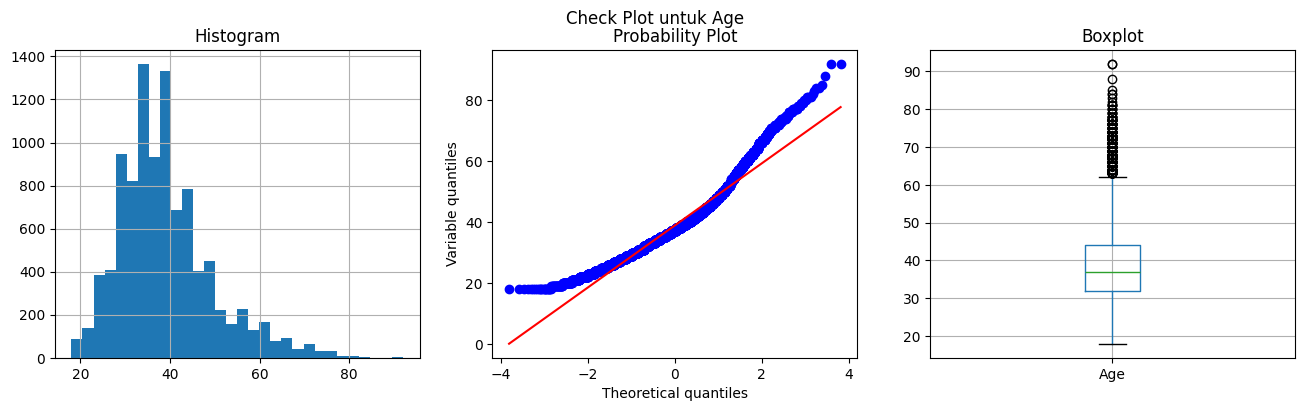

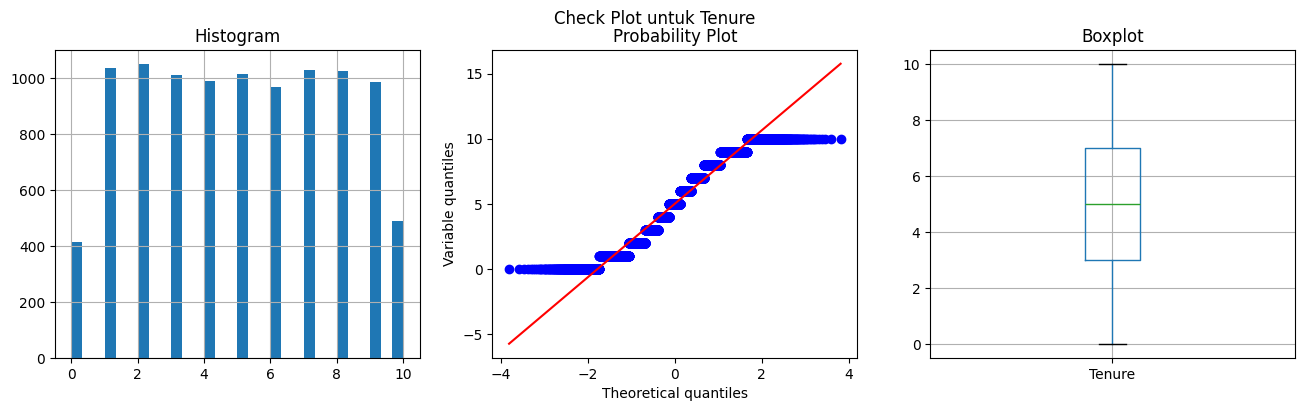

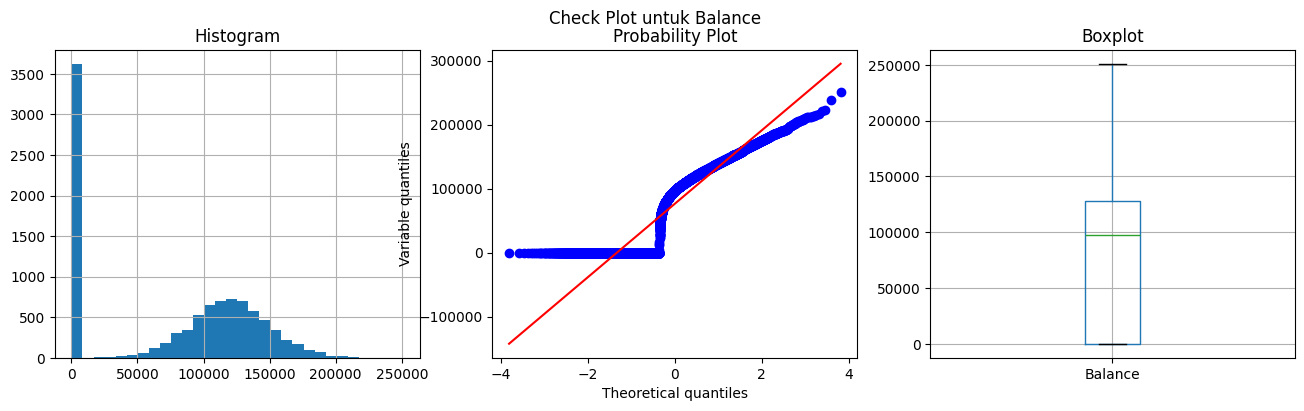

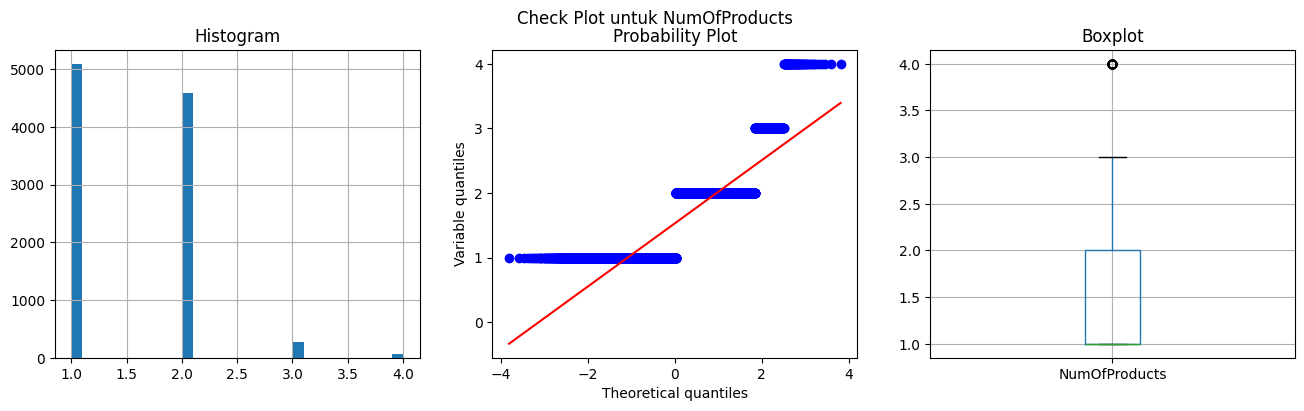

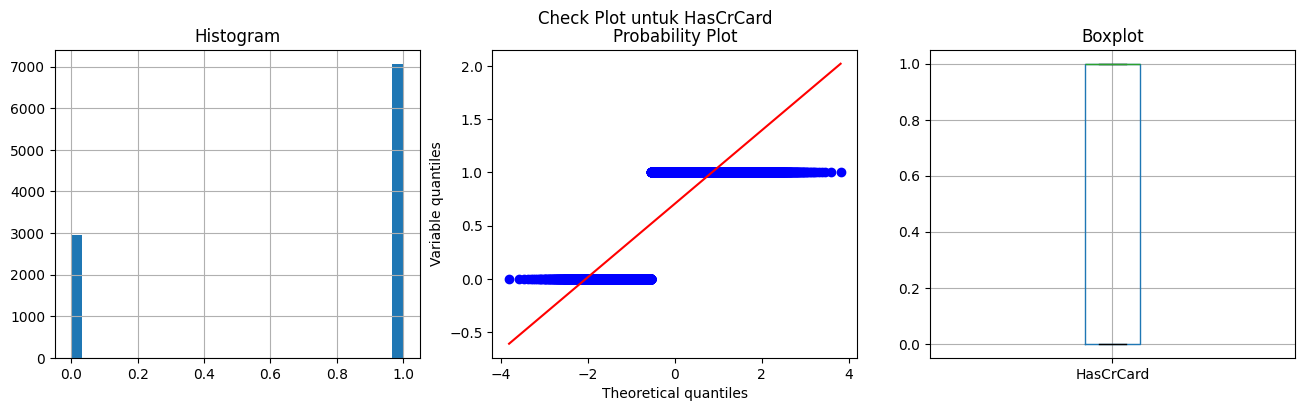

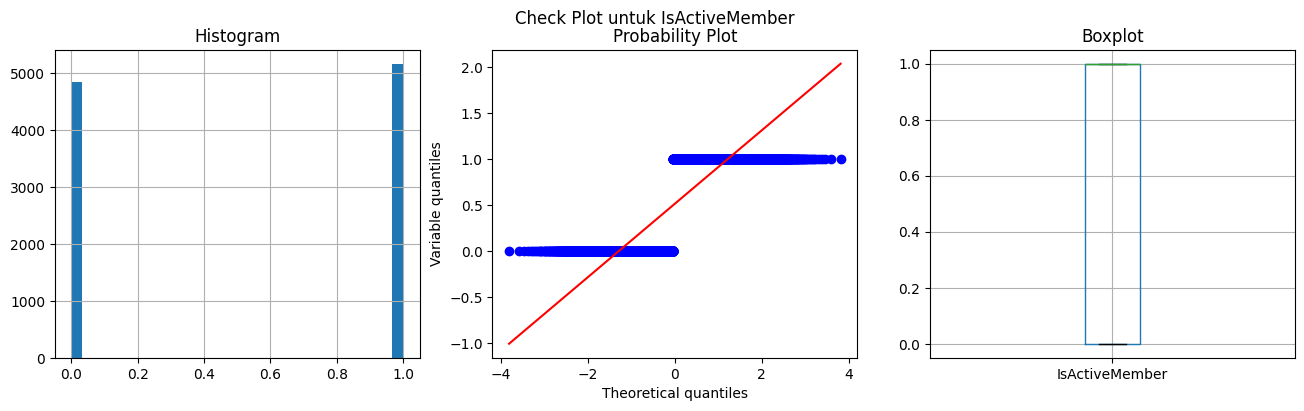

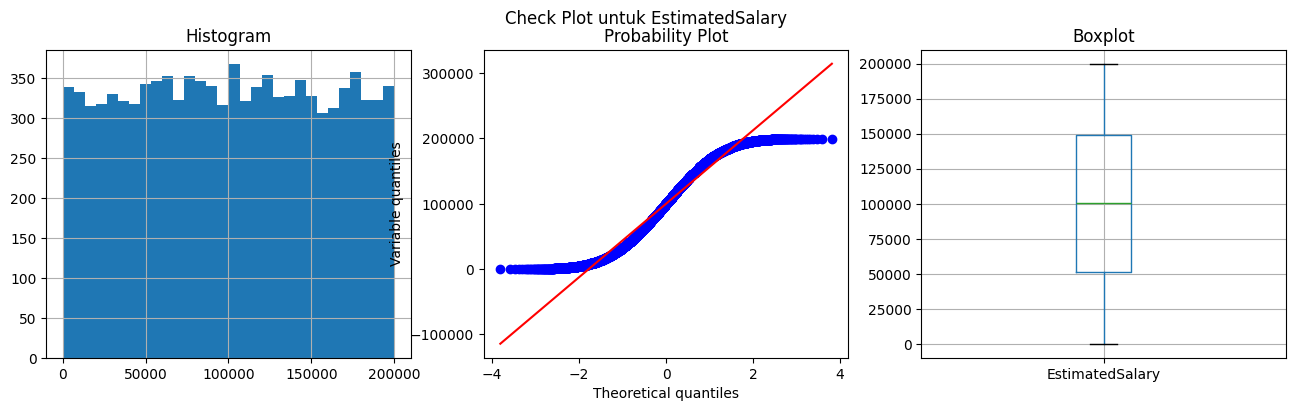

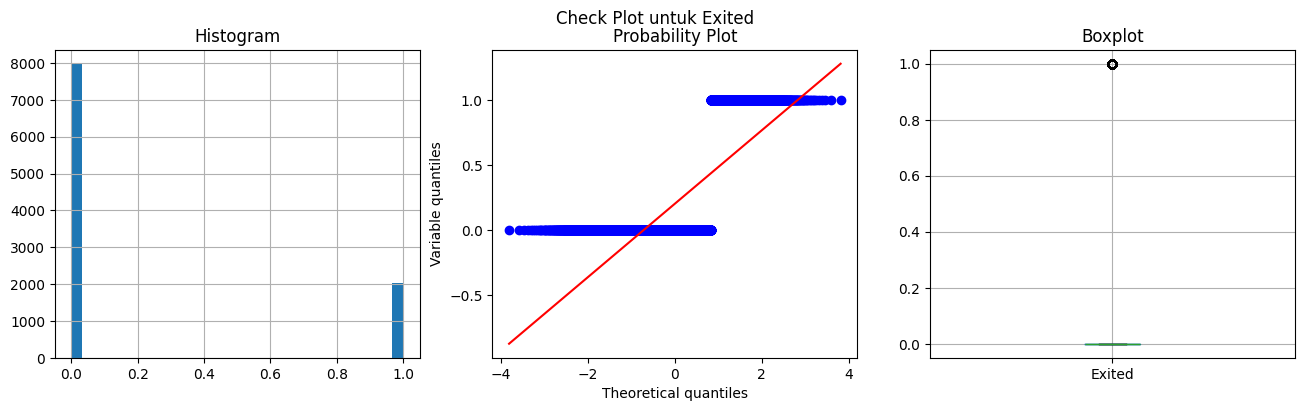

In [ ]:
for col in num_cols:
    check_plot(df, col)

In [ ]:
df['Exited'].value_counts()

,count
Exited,
0,7963
1,2037


### Insight
- Missing Values:
  - tidak terdapat duplikat pada data.

- Duplicate:
  - tidak terdapat duplikat pada data

- Outlier:
  - Setelah dilakukan pengecekan baik menggunakan IQR dan juga Visual pada setiap kolom numerik
  - tidak ditemukan adanya outlier yang extreme.
  - pada kolom `Exited` terdapat outlier extreme, namun tidak akan di handle karna kolom ini menunjukan data aktual customer.

## EDA

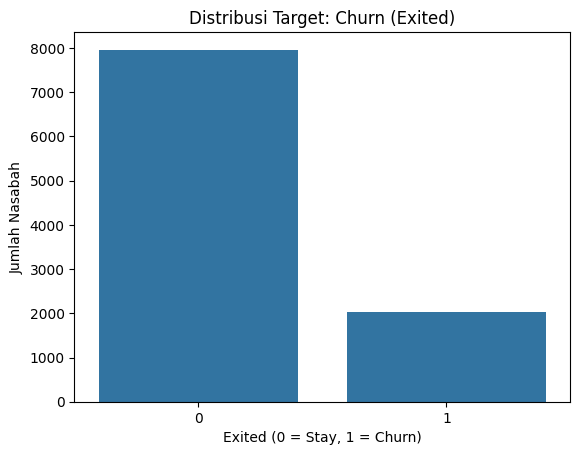

In [ ]:
sns.countplot(x='Exited', data=df)
plt.title('Distribusi Target: Churn (Exited)')
plt.xlabel('Exited (0 = Stay, 1 = Churn)')
plt.ylabel('Jumlah Nasabah')
plt.show()

**Insight**

- Mayoritas nasabah tidak churn (sekitar 80%)
- Hanya sekitar 20% nasabah yang churn

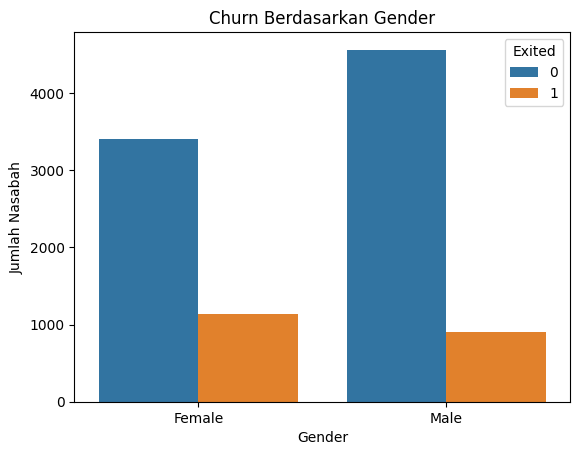

In [ ]:
sns.countplot(x='Gender', hue='Exited', data=df)
plt.title('Churn Berdasarkan Gender')
plt.xlabel('Gender')
plt.ylabel('Jumlah Nasabah')
plt.legend(title='Exited')
plt.show()

**Insight**

- Proporsi churn pada perempuan lebih tinggi dibandingkan laki-laki

- Meskipun jumlah nasabah laki-laki lebih banyak, nasabah perempuan lebih rentan churn

- Perlu pendekatan khusus untuk mempertahankan pelanggan perempuan

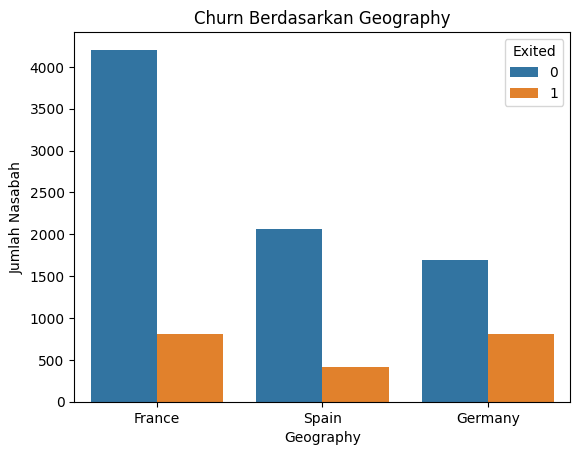

In [ ]:
sns.countplot(x='Geography', hue='Exited', data=df)
plt.title('Churn Berdasarkan Geography')
plt.xlabel('Geography')
plt.ylabel('Jumlah Nasabah')
plt.legend(title='Exited')
plt.show()

**Insight**
- Nasabah dari Jerman menunjukkan tingkat churn tertinggi

- Nasabah dari Spanyol memiliki churn paling rendah

- Perbedaan perilaku per negara ini bisa menjadi dasar segmentasi strategi retensi

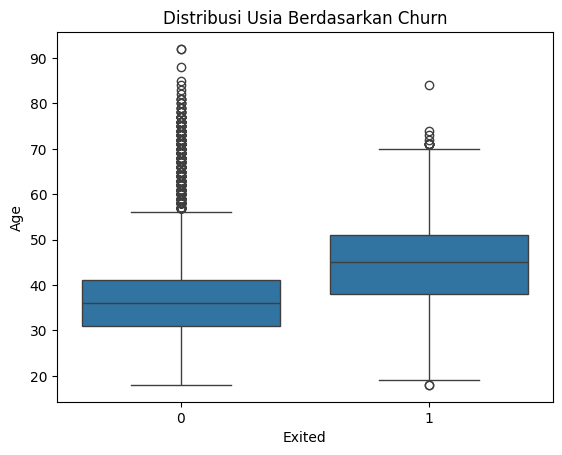

In [ ]:
sns.boxplot(x='Exited', y='Age', data=df)
plt.title('Distribusi Usia Berdasarkan Churn')
plt.xlabel('Exited')
plt.ylabel('Age')
plt.show()

**Insight**
- Pelanggan yang churn cenderung lebih tua (median usia lebih tinggi)

- Sebagian besar pelanggan churn berusia 40–50 tahun ke atas

- Menunjukkan bahwa usia tua adalah indikator risiko churn → bank bisa mempertimbangkan program loyalitas usia lanjut

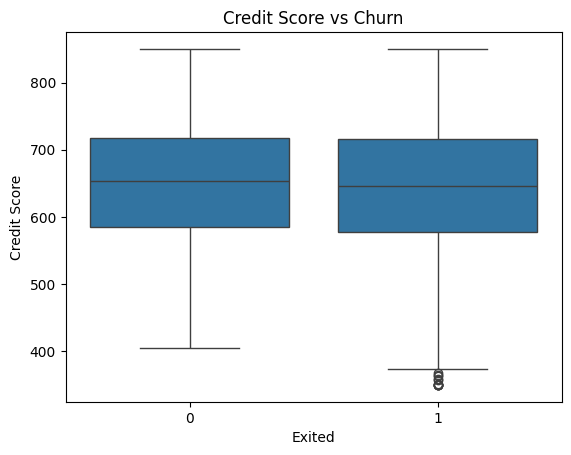

In [ ]:
sns.boxplot(x='Exited', y='CreditScore', data=df)
plt.title('Credit Score vs Churn')
plt.xlabel('Exited')
plt.ylabel('Credit Score')
plt.show()

**Insight**

- Tidak ada perbedaan signifikan pada distribusi skor kredit antara churn dan tidak

- Korelasi dengan churn juga sangat lemah (-0.03)

- Credit Score tidak terlalu berpengaruh terhadap churn di dataset ini

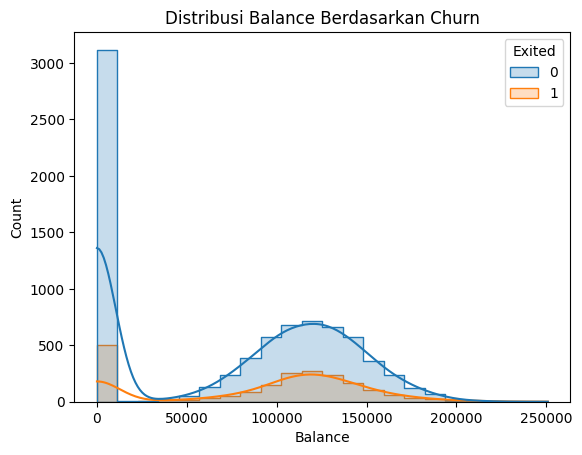

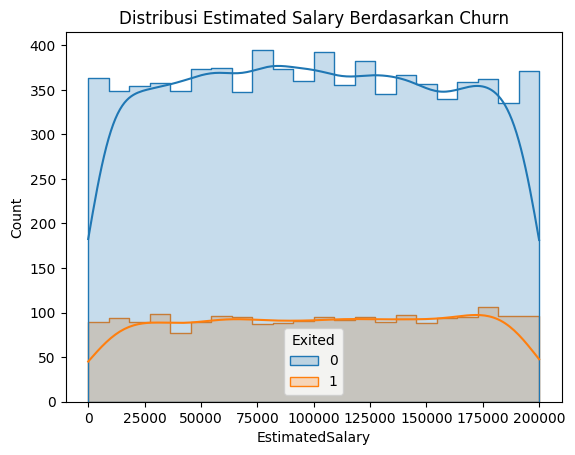

In [ ]:
sns.histplot(data=df, x='Balance', hue='Exited', kde=True, element="step")
plt.title('Distribusi Balance Berdasarkan Churn')
plt.show()

sns.histplot(data=df, x='EstimatedSalary', hue='Exited', kde=True, element="step")
plt.title('Distribusi Estimated Salary Berdasarkan Churn')
plt.show()

**Insight**
- Balance

  - Banyak pelanggan dengan balance = 0 dan tidak churn

  - Pelanggan dengan balance tinggi justru lebih banyak yang churn

  - Insight ini cukup mengejutkan dan perlu pendalaman — apakah nasabah dengan saldo tinggi memiliki ekspektasi layanan yang lebih besar?

- Salary
  - Distribusi gaji terlihat merata di antara yang churn dan tidak

  - Tidak ada pola signifikan antara gaji dan churn

  - Korelasi juga nyaris nol → bisa dianggap kurang relevan

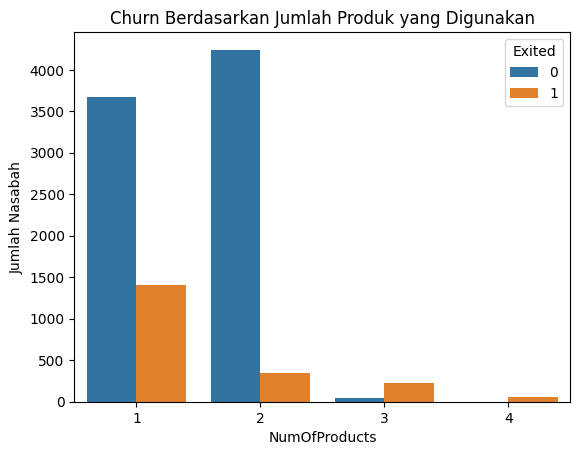

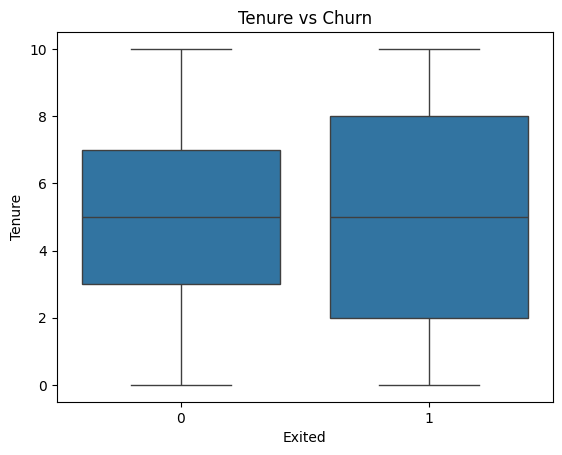

In [ ]:
sns.countplot(x='NumOfProducts', hue='Exited', data=df)
plt.title('Churn Berdasarkan Jumlah Produk yang Digunakan')
plt.xlabel('NumOfProducts')
plt.ylabel('Jumlah Nasabah')
plt.show()

sns.boxplot(x='Exited', y='Tenure', data=df)
plt.title('Tenure vs Churn')
plt.xlabel('Exited')
plt.ylabel('Tenure')
plt.show()

**Insight**
- Produk:
  - Churn tertinggi pada pelanggan yang menggunakan 1 produk

  - Pelanggan dengan 2 produk sangat kecil kemungkinan churn

  - Namun, penggunaan 3 atau 4 produk justru meningkatkan risiko churn kembali

  - Hal ini bisa menunjukkan bahwa produk tambahan tidak otomatis meningkatkan loyalitas

- Tenure:
  - Tidak ada perbedaan jelas dalam tenure

  - Median tenure serupa antara yang churn dan tidak churn

  - Menunjukkan bahwa lama menjadi nasabah belum tentu menentukan churn

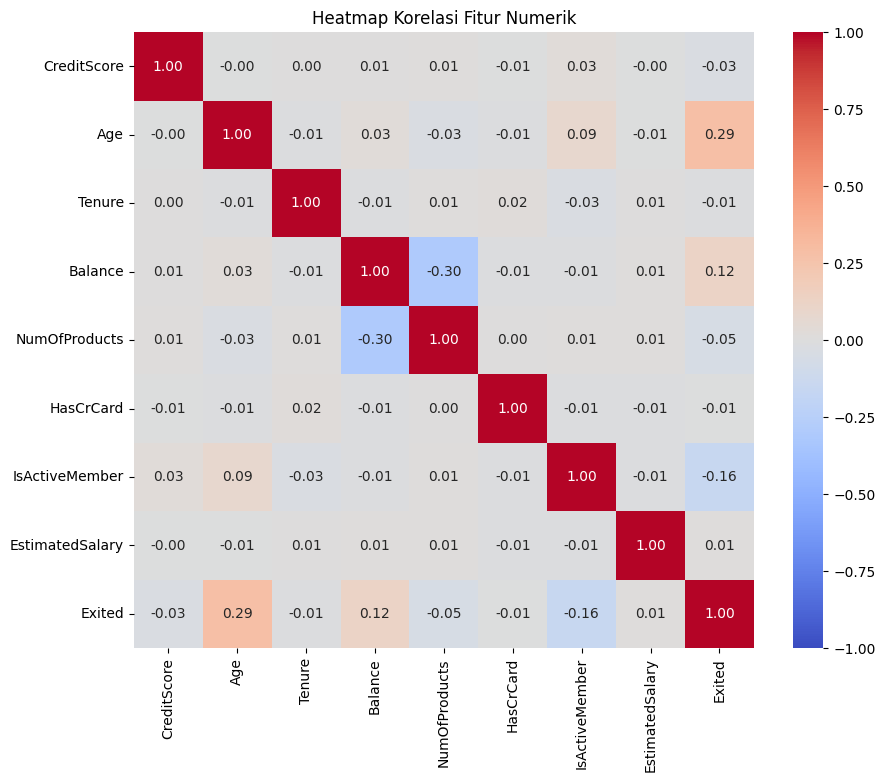

In [ ]:
# Drop kolom yang tidak relevan
df_corr = df.drop(columns=['CustomerId', 'RowNumber'])

# Hitung korelasi
corr = df_corr.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1
)
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

**Insight**
- Age	`+0.29`	Korelasi positif terkuat → makin tua, makin besar risiko churn

- IsActiveMember	`-0.16`	Korelasi negatif → member aktif cenderung tidak churn

- Balance	`+0.12`	Korelasi lemah positif


### Summary

- Pelanggan yang churn cenderung berusia lebih tua dan kurang aktif sebagai anggota bank.
- Nasabah dari Jerman menunjukkan tingkat churn yang lebih tinggi dibandingkan negara lain.
- Selain itu, pelanggan yang hanya menggunakan satu produk memiliki kemungkinan churn lebih besar dibandingkan mereka yang menggunakan dua produk.
- Beberapa fitur seperti Credit Score dan Estimated Salary tampaknya tidak memiliki pengaruh signifikan terhadap churn.

## Feature Engineering

In [ ]:
#Age + IsActiveMember
df['AgeByActivity'] = df['Age'] * df['IsActiveMember']

In [ ]:
# 0 Balance
df['HasBalance'] = df['Balance'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# EstimatedSalary + NumOfProducts
df['IncomePerProduct'] = df['EstimatedSalary'] / (df['NumOfProducts'] + 0.01)  # Hindari div/0

In [ ]:
# Tenure
df['TenureGroup'] = pd.cut(df['Tenure'], bins=[-1,2,5,10], labels=['New','Mid','Loyal'])

In [ ]:
# Set CustomerId sebagai index
df.set_index('CustomerId', inplace=True)

In [ ]:
# Drop kolom yang tidak diperlukan
df.drop(columns=['RowNumber', 'Surname'], inplace=True)

In [ ]:
df.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeByActivity,HasBalance,IncomePerProduct,TenureGroup
CustomerId,,,,,,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,42,0,100345.425743,New
15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,41,1,111428.297030,New
15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0,1,37851.019934,Loyal
15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0,46679.915423,New
15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,43,1,78301.089109,New
15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,0,1,74505.825871,Loyal
15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0,50,0,5006.368159,Loyal
15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,0,1,29762.314214,Mid
15792365,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,44,1,37283.830846,Mid


### Insight

- `AgeByActivity`
Dibuat dari perkalian antara usia `Age` dan status keaktifan `IsActiveMember`

  - Tujuannya untuk melihat apakah nasabah yang lebih tua dan aktif memiliki pengaruh terhadap churn.

- `HasBalance`
- Fitur baru berbentuk biner: 1 jika nasabah memiliki saldo (Balance > 0), dan 0 jika tidak.
  - Fitur ini menyederhanakan interpretasi apakah kepemilikan saldo berpengaruh terhadap keputusan untuk tetap atau berhenti menjadi nasabah.

- `IncomePerProduct`
- Menghitung estimasi gaji yang dibagi jumlah produk yang dimiliki.
  - Tujuannya untuk menangkap tingkat “nilai ekonomi per produk” yang bisa menjadi indikator kepuasan atau loyalitas.

- `TenureGroup`
- Mengelompokkan lama menjadi nasabah (Tenure) ke dalam tiga kategori:

`New: <2 tahun`

`Mid: 2–5 tahun`

`Loyal: >5 tahun`

  - Ini berguna untuk mengetahui apakah loyalitas waktu berdampak terhadap churn.

## Encoding

In [ ]:
# Gender: Female = 0, Male = 1
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

# TenureGroup: New = 0, Mid = 1, Loyal = 2
df['TenureGroup'] = df['TenureGroup'].map({'New': 0, 'Mid': 1, 'Loyal': 2})

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# OneHot untuk Geography
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
encoded_array = encoder.fit_transform(df[['Geography']])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Geography']), index=df.index)

In [ ]:
df = pd.concat([df.drop(['Geography'], axis=1), encoded_df], axis=1)

In [ ]:
df.head(10)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeByActivity,HasBalance,IncomePerProduct,TenureGroup,Geography_Germany,Geography_Spain
CustomerId,,,,,,,,,,,,,,,,
15634602,619,0,42,2,0.00,1,1,1,101348.88,1,42,0,100345.425743,0,0.0,0.0
15647311,608,0,41,1,83807.86,1,0,1,112542.58,0,41,1,111428.297030,0,0.0,1.0
15619304,502,0,42,8,159660.80,3,1,0,113931.57,1,0,1,37851.019934,2,0.0,0.0
15701354,699,0,39,1,0.00,2,0,0,93826.63,0,0,0,46679.915423,0,0.0,0.0
15737888,850,0,43,2,125510.82,1,1,1,79084.10,0,43,1,78301.089109,0,0.0,1.0
15574012,645,1,44,8,113755.78,2,1,0,149756.71,1,0,1,74505.825871,2,0.0,1.0
15592531,822,1,50,7,0.00,2,1,1,10062.80,0,50,0,5006.368159,2,0.0,0.0
15656148,376,0,29,4,115046.74,4,1,0,119346.88,1,0,1,29762.314214,1,1.0,0.0
15792365,501,1,44,4,142051.07,2,0,1,74940.50,0,44,1,37283.830846,1,0.0,0.0


## Multicollinearity

### Heatmap

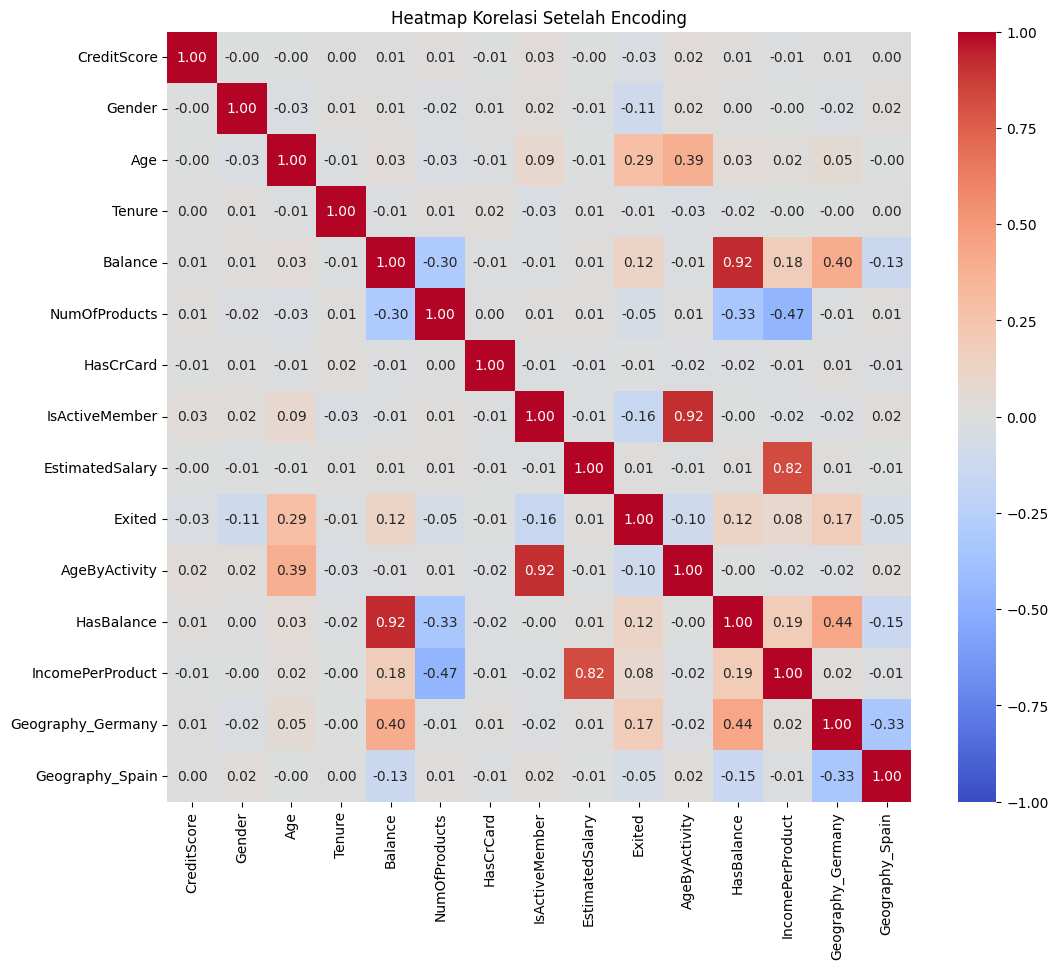

In [ ]:
num_df = df.select_dtypes(include='number')

corr = num_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Heatmap Korelasi Setelah Encoding")
plt.show()

### VIF Score

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

In [ ]:
X = add_constant(df)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,CreditScore,1.001989
2,Gender,1.013509
3,Age,3.275389
4,Tenure,7.301000
5,Balance,6.744204
6,NumOfProducts,3.538433
7,HasCrCard,1.002081
8,IsActiveMember,16.486346
9,EstimatedSalary,8.396275
10,Exited,1.264300


In [ ]:
df.drop(columns=['AgeByActivity', 'EstimatedSalary', 'HasBalance', 'TenureGroup'], inplace=True)

In [ ]:
X = add_constant(df)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,CreditScore,1.001648
2,Gender,1.013249
3,Age,1.110530
4,Tenure,1.002104
5,Balance,1.340550
6,NumOfProducts,1.389917
7,HasCrCard,1.001607
8,IsActiveMember,1.046626
9,Exited,1.181252
10,IncomePerProduct,1.288332


#### Insight

- VIF (Variance Inflation Factor):

  - Beberapa fitur menunjukkan nilai VIF tinggi:

  - IsActiveMember → 16.48

  - AgeByActivity → 19.76

  - IncomePerProduct → 10.81

  - TenureGroup → 7.30

- Nilai VIF > 10 menandakan multikolinearitas serius, dan disarankan untuk menghapus salah satu fitur yang redundant.

- Keputusan:

  - Fitur `AgeByActivity`, `HasBalance`, `IncomePerProduct`, `TenureGroup` di-drop karena memiliki korelasi tinggi dengan fitur lain dan menghasilkan VIF besar.

  - Hal ini bertujuan untuk menjaga stabilitas model dan menghindari distorsi interpretasi koefisien pada model linear.

- Kesimpulan:

  - Meski fitur baru memberikan sudut pandang tambahan, jika terbukti menyebabkan multikolinearitas yang kuat, lebih baik dihapus.

  - Keputusan ini menunjukkan bahwa proses feature engineering tidak hanya membuat fitur baru, tapi juga perlu dievaluasi ulang agar tidak mengganggu kualitas model.

## Scalling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X = df.drop(columns='Exited')
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
X_scaled_df.head(10)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,IncomePerProduct,Geography_Germany,Geography_Spain
0,0.538,0.0,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506790,0.0,0.0
1,0.516,0.0,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562770,0.0,1.0
2,0.304,0.0,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.191129,0.0,0.0
3,0.698,0.0,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.235724,0.0,0.0
4,1.000,0.0,0.337838,0.2,0.500246,0.000000,1.0,1.0,0.395443,0.0,1.0
5,0.590,1.0,0.351351,0.8,0.453394,0.333333,1.0,0.0,0.376273,0.0,1.0
6,0.944,1.0,0.432432,0.7,0.000000,0.333333,1.0,1.0,0.025229,0.0,0.0
7,0.052,0.0,0.148649,0.4,0.458540,1.000000,1.0,0.0,0.150272,1.0,0.0
8,0.302,1.0,0.351351,0.4,0.566170,0.333333,0.0,1.0,0.188264,0.0,0.0
9,0.668,1.0,0.121622,0.2,0.536488,0.000000,1.0,1.0,0.358644,0.0,0.0


In [ ]:
X_scaled_df.describe().T[['mean', 'std']]

,mean,std
CreditScore,0.601058,0.193307
Gender,0.545700,0.497932
Age,0.282727,0.141727
Tenure,0.501280,0.289217
Balance,0.304848,0.248696
NumOfProducts,0.176733,0.193885
HasCrCard,0.705500,0.455840
IsActiveMember,0.515100,0.499797
IncomePerProduct,0.374204,0.260240
Geography_Germany,0.250900,0.433553


#Processing

## Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = X_scaled_df
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Baseline Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

### Logistic Regression

In [ ]:
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_train_pred = logreg.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      6370
           1       0.61      0.21      0.31      1630

    accuracy                           0.81      8000
   macro avg       0.72      0.59      0.60      8000
weighted avg       0.78      0.81      0.77      8000



In [ ]:
y_test_pred = logreg.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.60      0.19      0.29       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



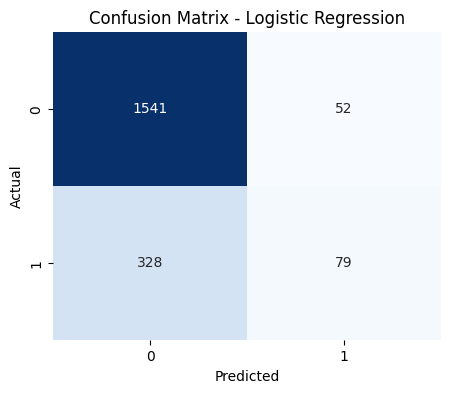

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_train_pred = knn.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      6370
           1       0.79      0.47      0.59      1630

    accuracy                           0.87      8000
   macro avg       0.83      0.72      0.76      8000
weighted avg       0.86      0.87      0.85      8000



In [ ]:
y_test_pred = knn.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1593
           1       0.61      0.34      0.43       407

    accuracy                           0.82      2000
   macro avg       0.73      0.64      0.66      2000
weighted avg       0.80      0.82      0.80      2000



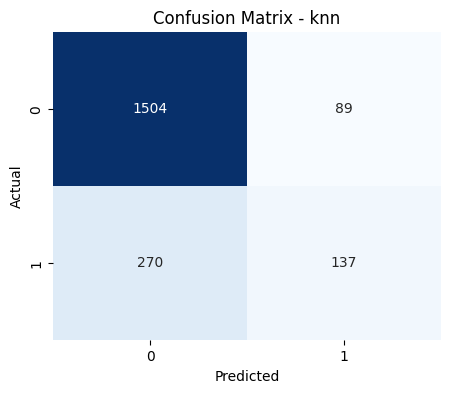

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - knn')
plt.show()

### Ramdom Forest

In [ ]:
rf = RandomForestClassifier(
    random_state=1000,
    n_estimators=1000,
    class_weight = {0: 0.265353, 1:0.734647}
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.265353, 1: 0.734647},
                       n_estimators=1000, random_state=1000)

In [ ]:
y_train_pred = rf.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6370
           1       1.00      1.00      1.00      1630

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [ ]:
y_test_pred = rf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.79      0.45      0.58       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000



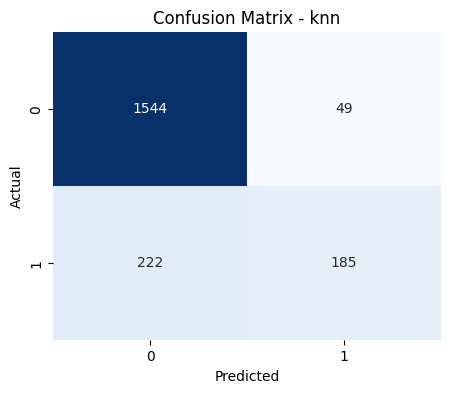

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - knn')
plt.show()

## Final Model

### KNN (Hyperparameter tunning)

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe_smote = ImbPipeline([
    ("scaler", MinMaxScaler()),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("knn", KNeighborsClassifier())
])

param_grid_smote = {
    "knn__n_neighbors": [5,7,9,11,13,15,17,19,21],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski", "manhattan"],
    "knn__p": [1,2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_smote = GridSearchCV(
    estimator=pipe_smote,
    param_grid=param_grid_smote,
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=0,
    refit=True
)

grid_smote.fit(X_train, y_train)
print("Best params (SMOTE):", grid_smote.best_params_)
print("Best CV score:", grid_smote.best_score_)

Best params (SMOTE): {'knn__metric': 'minkowski', 'knn__n_neighbors': 19, 'knn__p': 2, 'knn__weights': 'uniform'}
Best CV score: 0.69079754601227


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_curve
import numpy as np

# pakai estimator terbaik dari grid_smote
best_pipe = grid_smote.best_estimator_

# proba OOF di training (tidak bocor)
oof_prob = cross_val_predict(
    best_pipe, X_train, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method="predict_proba"
)[:, 1]

# pilih threshold sesuai target (pilih salah satu fungsi)
def pick_threshold_max_recall(y_true, y_scores, precision_floor=0.5):
    p, r, th = precision_recall_curve(y_true, y_scores)
    th_full = np.append(th, 1.0)
    mask = p >= precision_floor
    idx = np.argmax(r*mask) if np.any(mask) else np.argmax(r)
    return float(th_full[idx])

best_th = pick_threshold_max_recall(y_train, oof_prob, precision_floor=0.50)
print("Chosen threshold (train CV):", best_th)

Chosen threshold (train CV): 0.7368421052631579


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import seaborn as sns, matplotlib.pyplot as plt

# fit ulang di seluruh TRAIN
best_pipe.fit(X_train, y_train)

# proba & pred berdasarkan threshold terpilih
ytr_prob = best_pipe.predict_proba(X_train)[:, 1]
yte_prob = best_pipe.predict_proba(X_test)[:, 1]

ytr_pred = (ytr_prob >= best_th).astype(int)
yte_pred = (yte_prob >= best_th).astype(int)

# --- REPORT TRAIN ---
print("=== Classification Report - Train ===")
print(classification_report(y_train, ytr_pred, zero_division=0))
print("Accuracy (train):", accuracy_score(y_train, ytr_pred))

# --- REPORT TEST ---
print("\n=== Classification Report - Test ===")
print(classification_report(y_test, yte_pred, zero_division=0))
print("Accuracy (test):", accuracy_score(y_test, yte_pred))
print("ROC AUC (test):", roc_auc_score(y_test, yte_prob))

=== Classification Report - Train ===
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      6370
           1       0.64      0.60      0.62      1630

    accuracy                           0.85      8000
   macro avg       0.77      0.76      0.76      8000
weighted avg       0.85      0.85      0.85      8000

Accuracy (train): 0.84875

=== Classification Report - Test ===
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1593
           1       0.51      0.42      0.46       407

    accuracy                           0.80      2000
   macro avg       0.68      0.66      0.67      2000
weighted avg       0.79      0.80      0.79      2000

Accuracy (test): 0.7995
ROC AUC (test): 0.7673744622897165


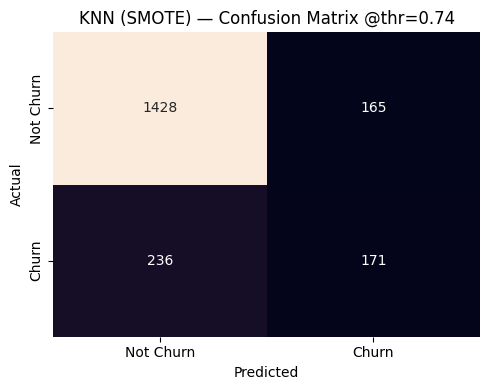

In [ ]:
cm = confusion_matrix(y_test, yte_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=['Not Churn','Churn'], yticklabels=['Not Churn','Churn'])
plt.title(f"KNN (SMOTE) — Confusion Matrix @thr={best_th:.2f}")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()

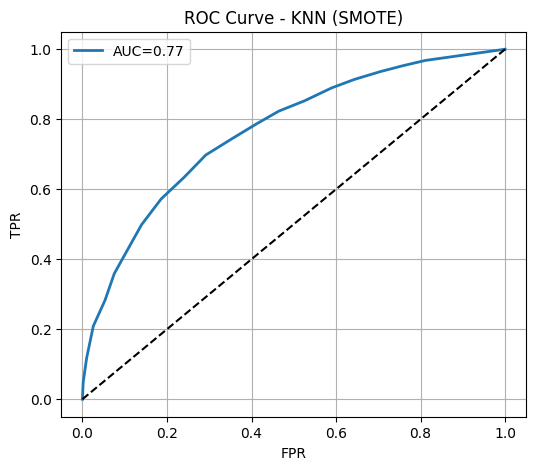

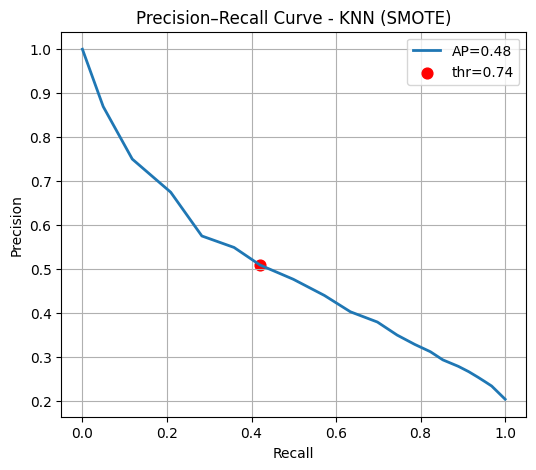

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

# ROC
fpr, tpr, _ = roc_curve(y_test, yte_prob)
auc = roc_auc_score(y_test, yte_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC={auc:.2f}")
plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve - KNN (SMOTE)'); plt.legend(); plt.grid(True); plt.show()

# PR + titik threshold terpilih
p, r, th = precision_recall_curve(y_test, yte_prob)
th_full = np.append(th, 1.0)
# cari indeks threshold yg paling dekat dgn best_th (untuk ditandai)
idx = np.argmin(np.abs(th_full - best_th))
ap = average_precision_score(y_test, yte_prob)

plt.figure(figsize=(6,5))
plt.plot(r, p, lw=2, label=f"AP={ap:.2f}")
plt.scatter(r[idx], p[idx], c='red', s=60, label=f"thr={best_th:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve - KNN (SMOTE)"); plt.legend(); plt.grid(True); plt.show()

# Insight Utama


1. Segmentasi Churn

- Pelanggan dengan usia menengah ke atas (40+) memiliki tingkat churn lebih tinggi dibanding usia muda.

- Nasabah dengan jumlah produk hanya 1 lebih rentan churn dibanding yang memiliki lebih dari 1 produk.

- Pelanggan dengan balance = 0 justru memiliki tingkat churn lebih rendah dibanding yang memiliki saldo sedang.

- Nasabah dengan geografi tertentu (misalnya dari France) menunjukkan tingkat churn yang lebih tinggi dibanding negara lain.

- Skor kredit yang rendah (CreditScore < 600) berasosiasi dengan churn yang lebih tinggi.

2. Faktor Interaksi

- Kombinasi usia tua + aktivitas rendah memperkuat risiko churn.

- Nasabah dengan tenure singkat (0–3 tahun) memiliki churn rate lebih tinggi dibanding nasabah lama.

3. Hasil Model

- Model KNN setelah tuning memberikan keseimbangan terbaik antara recall dan precision.

- Recall tinggi berarti model cukup baik dalam menangkap nasabah yang berpotensi churn (mengurangi loss pelanggan).

# Rekomendasi Bisnis
1. Program Retensi Berdasarkan Usia

- Buat program loyalitas atau penawaran khusus untuk nasabah usia 40 tahun ke atas.

- Edukasi dan engagement khusus untuk mengurangi churn di segmen ini.

2. Bundling Produk

- Dorong nasabah dengan 1 produk untuk menambah produk lain (misalnya tabungan + kartu kredit).

- Tawarkan diskon biaya administrasi atau bunga khusus untuk bundling.

3. Geographic-Focused Campaign

- Untuk wilayah dengan churn tinggi (contoh: France), buat campaign personalisasi, misalnya promo lokal atau kolaborasi merchant.

4. Early Tenure Engagement

- 3 bulan pertama adalah masa kritis, berikan welcome package, edukasi layanan, dan follow-up aktif dari customer service.

5. Proaktif pada Risiko Tinggi

- Gunakan skor prediksi churn model untuk menghubungi lebih dulu nasabah berisiko tinggi sebelum mereka memutuskan keluar.